<a href="https://colab.research.google.com/github/girijeshcse/chatbot_savy/blob/anish/notebooks/Initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/Data Set - industrial_safety_and_health_database_with_accidents_description.csv')

In [9]:
data.head(10)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
5,5,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...
6,6,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...
7,7,2016-01-17 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic..."
8,8,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...
9,9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


From the above info, we can see that there are no null values in the data set.

- From the above data, we can see that the first column is merely an index, which we don't need and we can drop it.

- Data column is actually the date, which is not needed for building our NLP model but we can see if we need this for any EDA, later we can drop it.

- Countries column can be used for doing some EDA to see how many accidents happen in a particular country and if some countries have more safety risk compared to others.

- Local column can also be used for some EDA to identify which cities are mode accident prone, will drop it later before model training.

- Industry sector can also be used for EDA to identify industries which have more safety risks.

- Accident level is our target column which we need to be able to predict based on accident description.

- Potential Accident level just indicates what could have been the severity of the accident.

- Genre is basically Gender, we will use this column also for EDA to see distribution among male/female but won't be needed to train our model.

- Employee or Third Party column can also be used for some EDA but not needed for model training.

- Critical Risk basically identifies the area/component where accident has happened.

- Description basically is the textual information about the accident which we will be using to predict the accident level. We will cleanse and convert this text into vectors which will then be passed to our models for training/testing.

In [36]:
data.groupby(by=['Countries', 'Local']).count().sort_values(['Countries', 'Description'],ascending=False)

Unnamed: 0  Data  ...  Critical Risk  Description
Countries  Local                       ...                            
Country_03 Local_10          44    44  ...             44           44
Country_02 Local_05          59    59  ...             59           59
           Local_08          27    27  ...             27           27
           Local_02          24    24  ...             24           24
           Local_07          14    14  ...             14           14
           Local_12           4     4  ...              4            4
           Local_09           2     2  ...              2            2
Country_01 Local_03          90    90  ...             90           90
           Local_01          57    57  ...             57           57
           Local_04          56    56  ...             56           56
           Local_06          46    46  ...             46           46
           Local_11           2     2  ...              2            2

[12 rows x 9 columns]

From the above distribution we can see that the most number of accidents have happened in Local_03 from Country_01 followed by Local_05 from Country_02.


If we look closely into the above data, Country_01 has more accidents across different cities compared to other two countries.

With this observation, I think we can say that Country_01 is less safe compared to others.

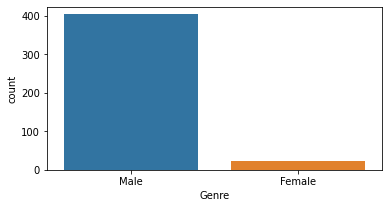

In [64]:
# Lets check the distribution of the accidents among male and female.

plt.rcParams["figure.figsize"] = (6,3)
sns.countplot(x=data['Genre']);

As we can see that there's a huge skew between the accidents among males and females which can be considered obvious as the number of males working in Industrial sectors are way way more than number of females.

In [45]:
# Adds two new columns for Year wise and month wise distribution.
data['Month_Year'] = data['Data'].apply(lambda x: x[:7])
data['Year'] = data['Data'].apply(lambda x: x[:4])

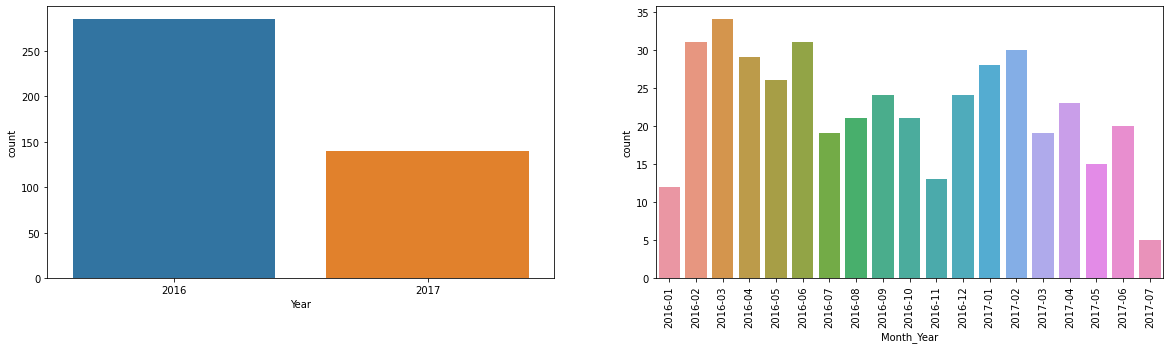

In [66]:
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (20,5)
plt.xticks(rotation=90)
sns.countplot(x=data['Year'], ax=ax[0]);
sns.countplot(x=data['Month_Year'], ax=ax[1]);
fig.show()

From the above two distributions, we can see that number of accidents in 2016 were much more compared to 2017.

Also, if we see from the monthly distribution, we can see that the number of accidents are more in the month of Feb to Jun in 2016. There is no definite pattern that we can identify from this, though.

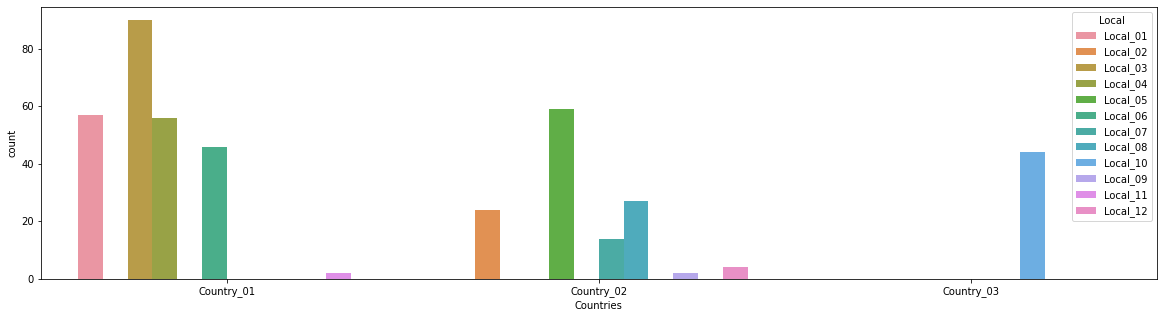

In [68]:
sns.countplot(x=data['Countries'], hue=data['Local']);